# PIGPVAE cooling R4 model
The main difference to traditional VAE model (Kigma et al., 2014) is that instead of using standard gaussian distibutions on the latent vector $\mathbf{Z} = [\mathbf{z}_1, \ldots, \mathbf{z}_L],$ where $\mathbf{z}_l \sim \mathcal{N}(0, \sigma^2I),$ we use GPs that account for the depedency that we have in time. Therefore we have that $\mathbf{z}_l \sim \mathcal{N}(0, K(t,t'\mid \theta_l)),$ where $K$ is a function that models the correlation that we have in time. 

This is in principle a conditional (in time) generator. Another advantage of using GPs for the latent variables, is that we do not need the data to be equally spaced in time. It is also possible to condition on other features. For example, the outer temperature, solar irradiance, wind, ...

The main drawback with GPs is the cubic in data $\mathcal{O}(N^3)$ cost and the vanilla GP model can not be trained in mini-batches.
To overcome the cost we can use reliable approximations (e.g. Titsias 2009) that reduce the cost to $\mathcal{O}(Nm^2),$ where $m$ is a user the number of so called inducing points (user choice, usually 20-30 is fine). At the same time there are two recent papers that make GPs ammenable to mini-batching (add refs).

In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from physics import NewtonsLaw
from GP import *
from VAE_utils import AnnealingStrategy

# from Models.PIGPVAE_cooling import PIGPVAE
# from Models.PIGPVAE_heating import PIGPVAE
from Models.PIGPVAE_lognorm import PIGPVAE

import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file
warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)


In [2]:
# Import RICO data 
file_path = '../Data/RICO4_Dataset_processed.hdf'
df = pd.read_hdf(file_path)
#  define surrounding temperature
df.loc[:, 'sur_temp'] = (df['RTD417'] + df['B.ASTRHT2.T'])/2
df_c = df.copy()
df_c = df[df['temp_change_class'] == 'c']
def select_points(group):
    return group.iloc[::10]  # Select every 10th row
df_c = df_c.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)
df_c = df_c.dropna()

/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_10103/3618831305.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_c = df_c.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)


In [3]:
class RICO4Dataset(Dataset):
    def __init__(self, df, select_var):
        self.df = df
        self.select_var = select_var
        self.unique_batches = df['interval'].unique()

    def __len__(self):
        return len(self.unique_batches)

    def __getitem__(self, idx):
        batch = self.unique_batches[idx]
        temp = self.df[self.df['interval'] == batch][self.select_var]
        
        # Normalize and convert to tensors
        ti = torch.tensor(temp['time_within_interval'].to_numpy() / 240, dtype=torch.float32)
        Ts = torch.tensor(temp['sur_temp'].to_numpy(), dtype=torch.float32)
        heat_obs = torch.tensor(temp['B.RTD1'].to_numpy(), dtype=torch.float32)
        
        # Stack the tensors to create the input batch
        x_batch = torch.stack((heat_obs, Ts, ti), dim=1)
        
        return x_batch
# Initialize the dataset and train_loader
select_var = ['time_within_interval', 'sur_temp', 'B.RTD1']
dataset = RICO4Dataset(df_c,select_var)
# Split the dataset into above_24 and below_24
above_24_data = []
below_24_data = []

for idx in range(len(dataset)):
    x_batch = dataset[idx]
    starting_value = x_batch[0, 0].item()  # Get the starting value of B.RTD1
    if starting_value > 24:
        above_24_data.append(x_batch)
    else:
        below_24_data.append(x_batch)

# Define custom datasets for above_24 and below_24
class SubsetDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create DataLoader instances
above_24_dataset = SubsetDataset(above_24_data)
below_24_dataset = SubsetDataset(below_24_data)

train_loader = DataLoader(above_24_dataset, batch_size=1, shuffle=True)  # Adjust batch_size as needed
val_loader = DataLoader(below_24_dataset, batch_size=1, shuffle=True)

# Check DataLoader sizes
print(f"Number of batches in above_24_loader: {len(train_loader)}")
print(f"Number of batches in below_24_loader: {len(val_loader)}")

Number of batches in above_24_loader: 10
Number of batches in below_24_loader: 18


In [4]:
len(dataset)


28

In [5]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))

# Initialize the GP_inference
GP_inf = GP_inference(kernel)

# Initialize the VAE
torch.manual_seed(1)
model = PIGPVAE(GP_inf=GP_inf, 
                hidden_layers_encoder_delta=[10,10], 
                hidden_layers_encoder_phy=[10], 
                hidden_layers_decoder_delta=[10,10],
                activation_decoder_delta=nn.ReLU(),
                trainable_alpha=True,
                initial_alpha=0.1
               )

In [6]:
gp_params = []
base_params = []
alpha_params = []

for name, param in model.named_parameters():
    if 'GP' in name:
        gp_params.append(param)  # Gaussian Process parameters
    elif 'raw_alpha' in name:
        alpha_params.append(param)  # raw_alpha parameter(s)
    else:
        base_params.append(param)  # All other parameters

# Define learning rates for each parameter group
base_lr = 0.001     # Learning rate for base parameters
gp_lr = 0.0001      # Learning rate for GP parameters
alpha_lr = 0.0001     # Learning rate for raw_alpha

# Create separate parameter groups in the optimizer
opt = torch.optim.Adam([
    {'params': base_params, 'lr': base_lr},
    {'params': gp_params, 'lr': gp_lr},
    {'params': alpha_params, 'lr': alpha_lr}
])
opt.zero_grad()


In [7]:
def find_rbf_lengthscale(kernel):
    if isinstance(kernel, gpytorch.kernels.RBFKernel):
        return kernel.lengthscale.item()
    elif hasattr(kernel, 'base_kernel'):
        return find_rbf_lengthscale(kernel.base_kernel)
    elif hasattr(kernel, 'kernels'):
        for k in kernel.kernels:
            result = find_rbf_lengthscale(k)
            if result is not None:
                return result
    return None

In [8]:
t_uni=torch.tensor(
    [  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.]
)


Training Progress:   5%|▍         | 26/550 [00:01<00:31, 16.71it/s]

Epoch 27: Train Loss = 2.8983, KL_phy = 0.1250, KL_delta = -0.4708, MSE = 2.9000, CE = 1.8631, Reg_Loss = 0.0176, Alpha = 0.0987
Validation Loss = 2.1263, Val_KL_phy = 0.1099, Val_KL_delta = -0.4662, Val_MSE = 2.1280, Val_CE = 1.7689, Val_Reg_Loss = 0.0187, Val_Alpha = 0.0987


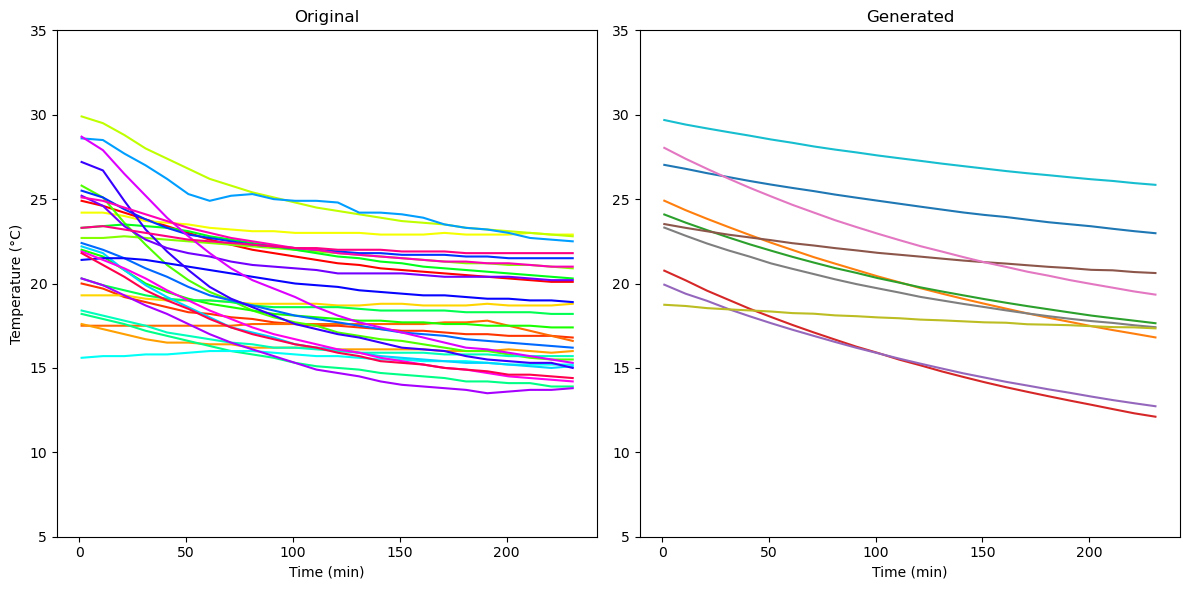

Training Progress:   9%|▉         | 52/550 [00:03<00:30, 16.42it/s]

Epoch 54: Train Loss = 1.7162, KL_phy = 0.0520, KL_delta = -0.4107, MSE = 1.7130, CE = 1.5184, Reg_Loss = 0.0694, Alpha = 0.0978
Validation Loss = 1.6182, Val_KL_phy = 0.0346, Val_KL_delta = -0.4159, Val_MSE = 1.6180, Val_CE = 1.4473, Val_Reg_Loss = 0.0404, Val_Alpha = 0.0978


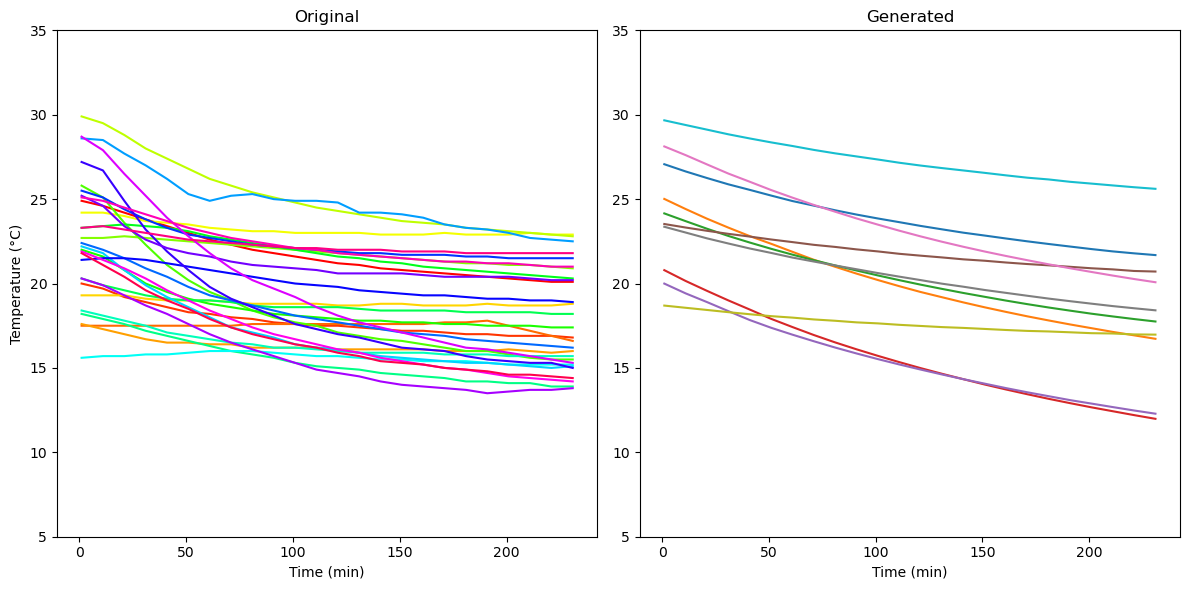

Training Progress:  15%|█▍        | 80/550 [00:05<00:28, 16.50it/s]

Epoch 81: Train Loss = 1.2261, KL_phy = 0.0500, KL_delta = -0.2009, MSE = 1.2005, CE = 0.7601, Reg_Loss = 0.2847, Alpha = 0.0952
Validation Loss = 1.9160, Val_KL_phy = 0.0288, Val_KL_delta = -0.2631, Val_MSE = 1.9032, Val_CE = 0.8095, Val_Reg_Loss = 0.1601, Val_Alpha = 0.0952


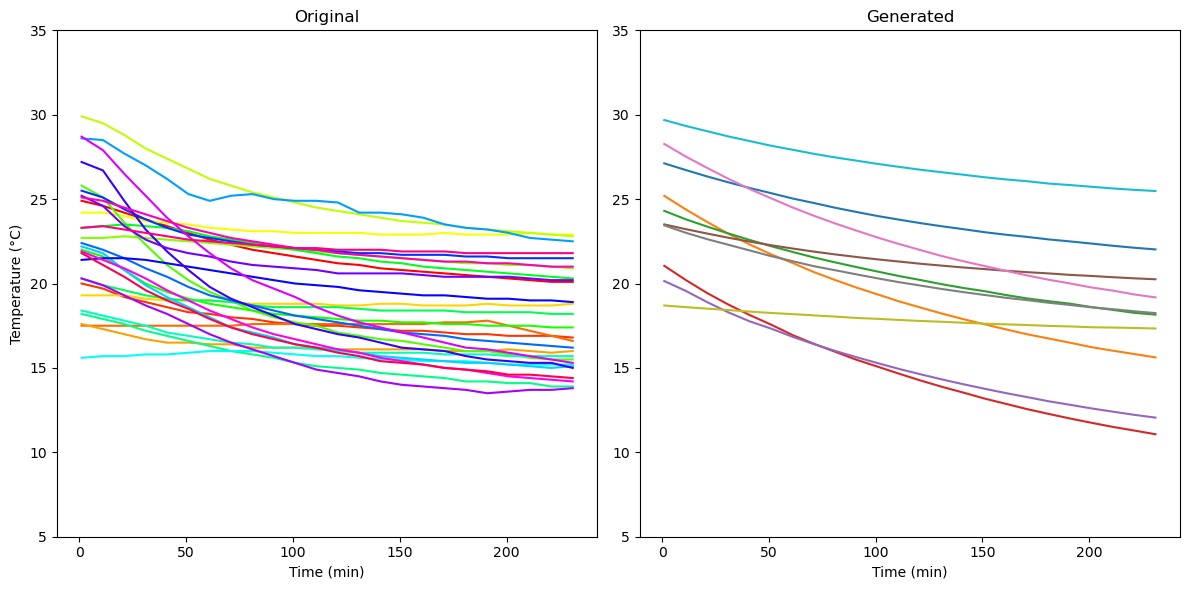

Training Progress:  19%|█▉        | 106/550 [00:07<00:27, 16.20it/s]

Epoch 108: Train Loss = 1.0482, KL_phy = 0.0584, KL_delta = -0.0109, MSE = 0.9939, CE = 0.3572, Reg_Loss = 0.5867, Alpha = 0.0917
Validation Loss = 1.5123, Val_KL_phy = 0.0392, Val_KL_delta = -0.1256, Val_MSE = 1.4846, Val_CE = 0.4471, Val_Reg_Loss = 0.3115, Val_Alpha = 0.0916


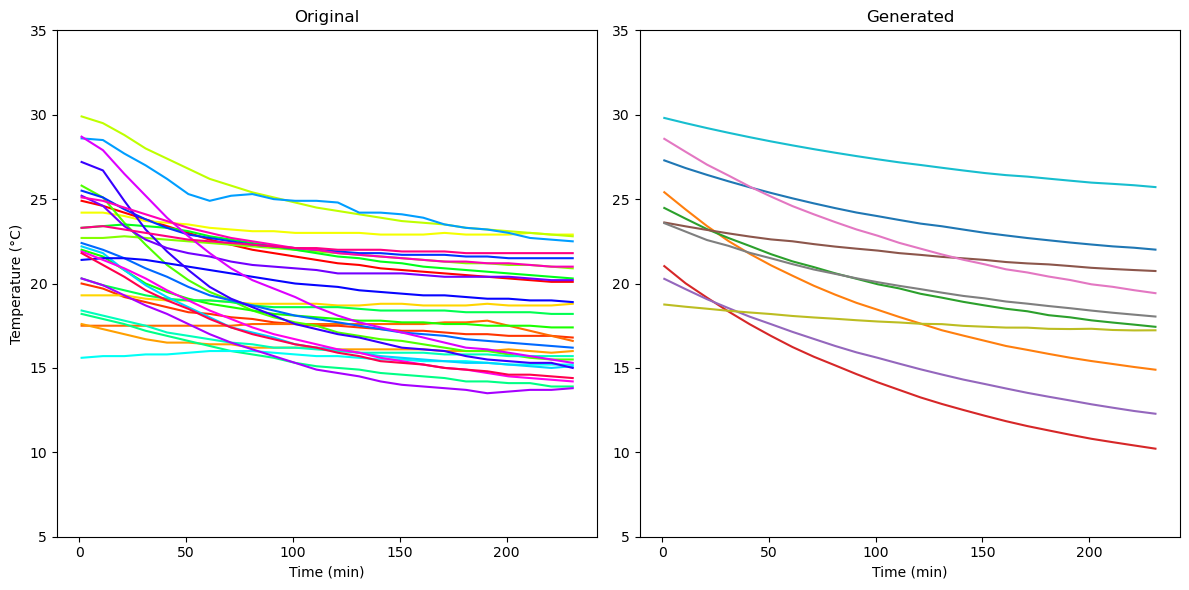

Training Progress:  24%|██▍       | 134/550 [00:08<00:25, 16.54it/s]

Epoch 135: Train Loss = 0.9020, KL_phy = 0.0884, KL_delta = 0.0778, MSE = 0.8497, CE = 0.1918, Reg_Loss = 0.5713, Alpha = 0.0887
Validation Loss = 2.1780, Val_KL_phy = 0.0577, Val_KL_delta = -0.0741, Val_MSE = 2.1488, Val_CE = 0.3492, Val_Reg_Loss = 0.3308, Val_Alpha = 0.0886


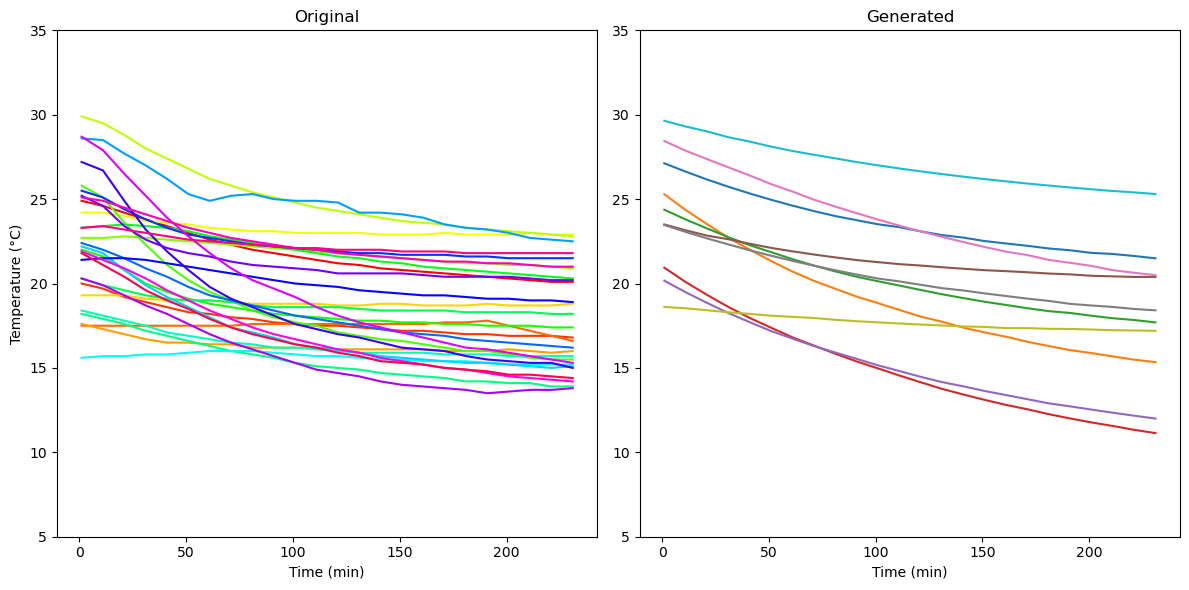

Training Progress:  29%|██▉       | 160/550 [00:10<00:23, 16.55it/s]

Epoch 162: Train Loss = 1.0750, KL_phy = 0.0938, KL_delta = 0.2403, MSE = 0.9838, CE = 0.1251, Reg_Loss = 1.0251, Alpha = 0.0857
Validation Loss = 1.3351, Val_KL_phy = 0.0657, Val_KL_delta = 0.0511, Val_MSE = 1.2908, Val_CE = 0.2053, Val_Reg_Loss = 0.5039, Val_Alpha = 0.0857


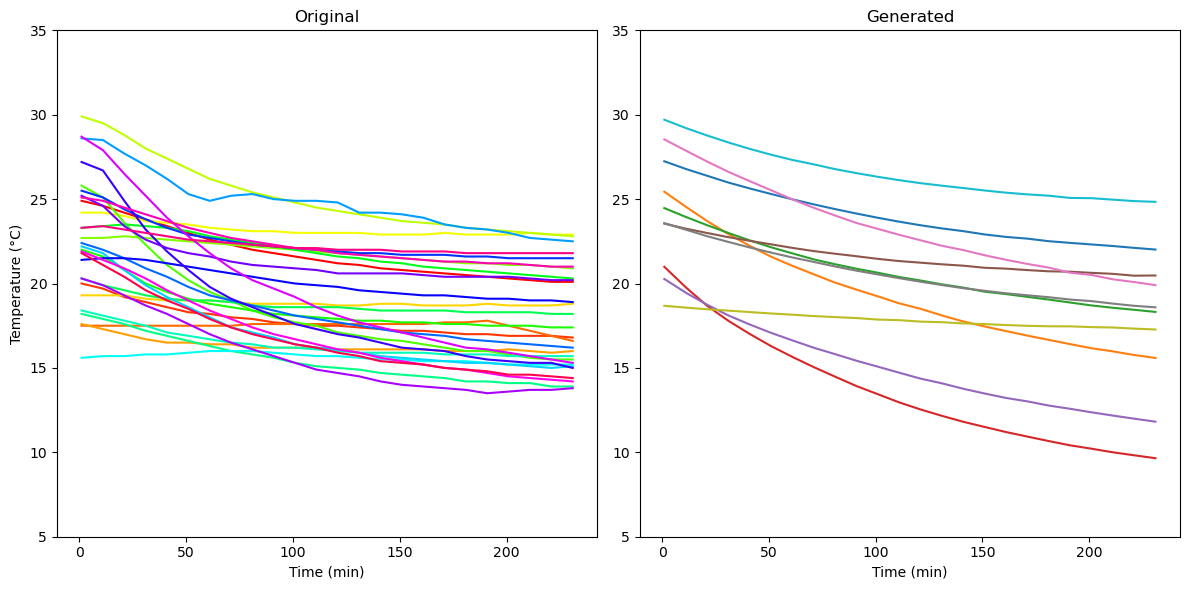

Training Progress:  34%|███▍      | 188/550 [00:12<00:21, 16.58it/s]

Epoch 189: Train Loss = 0.9016, KL_phy = 0.1448, KL_delta = 0.3274, MSE = 0.8192, CE = 0.1477, Reg_Loss = 0.9355, Alpha = 0.0831
Validation Loss = 1.5526, Val_KL_phy = 0.1121, Val_KL_delta = 0.1073, Val_MSE = 1.5053, Val_CE = 0.2466, Val_Reg_Loss = 0.5435, Val_Alpha = 0.0830


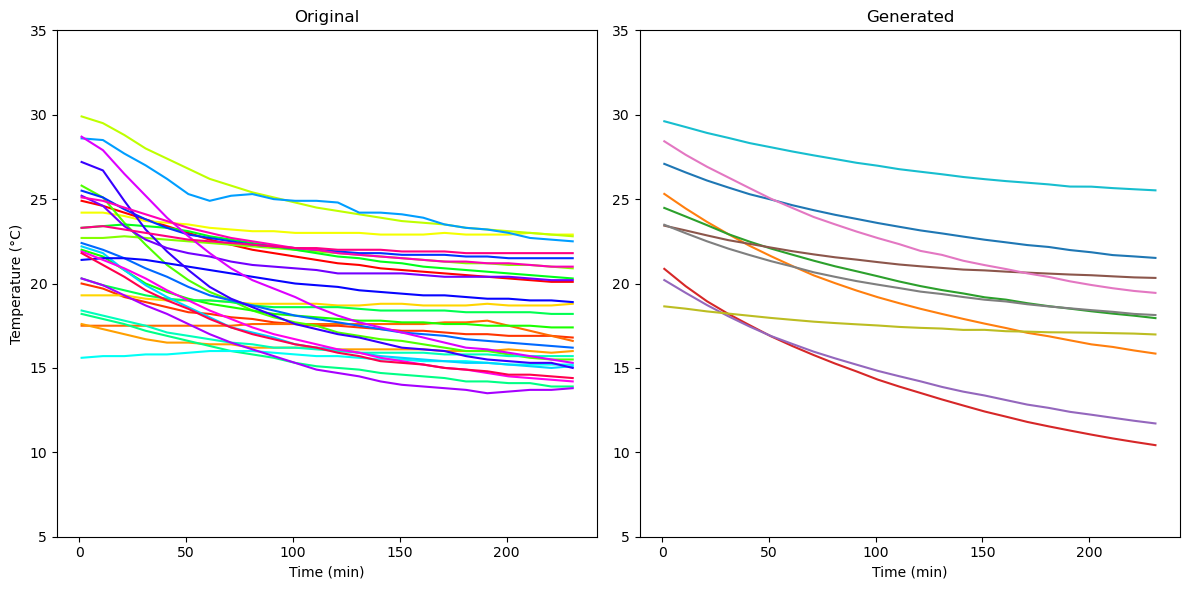

Training Progress:  39%|███▉      | 214/550 [00:14<00:20, 16.64it/s]

Epoch 216: Train Loss = 1.2266, KL_phy = 0.2811, KL_delta = 0.5004, MSE = 1.1280, CE = 0.1737, Reg_Loss = 1.1255, Alpha = 0.0806
Validation Loss = 1.6502, Val_KL_phy = 0.2388, Val_KL_delta = 0.2047, Val_MSE = 1.5901, Val_CE = 0.2994, Val_Reg_Loss = 0.6913, Val_Alpha = 0.0806


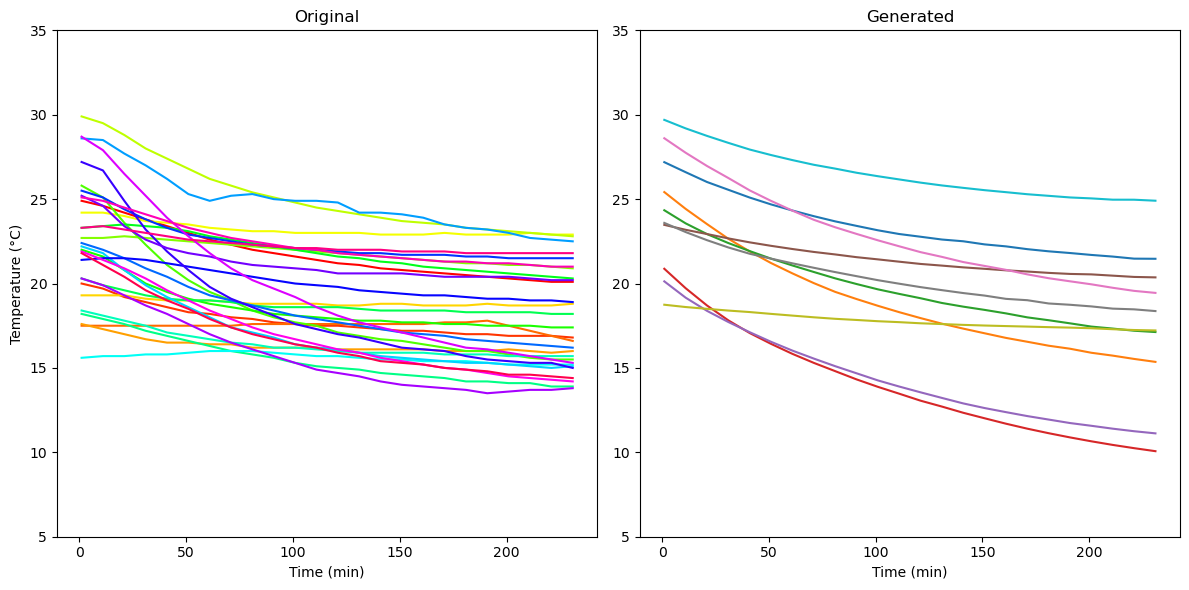

Training Progress:  44%|████▍     | 242/550 [00:16<00:18, 16.45it/s]

Epoch 243: Train Loss = 0.8143, KL_phy = 0.2885, KL_delta = 0.6056, MSE = 0.7208, CE = 0.1318, Reg_Loss = 1.0785, Alpha = 0.0784
Validation Loss = 1.8086, Val_KL_phy = 0.2440, Val_KL_delta = 0.2858, Val_MSE = 1.7508, Val_CE = 0.2032, Val_Reg_Loss = 0.6695, Val_Alpha = 0.0784


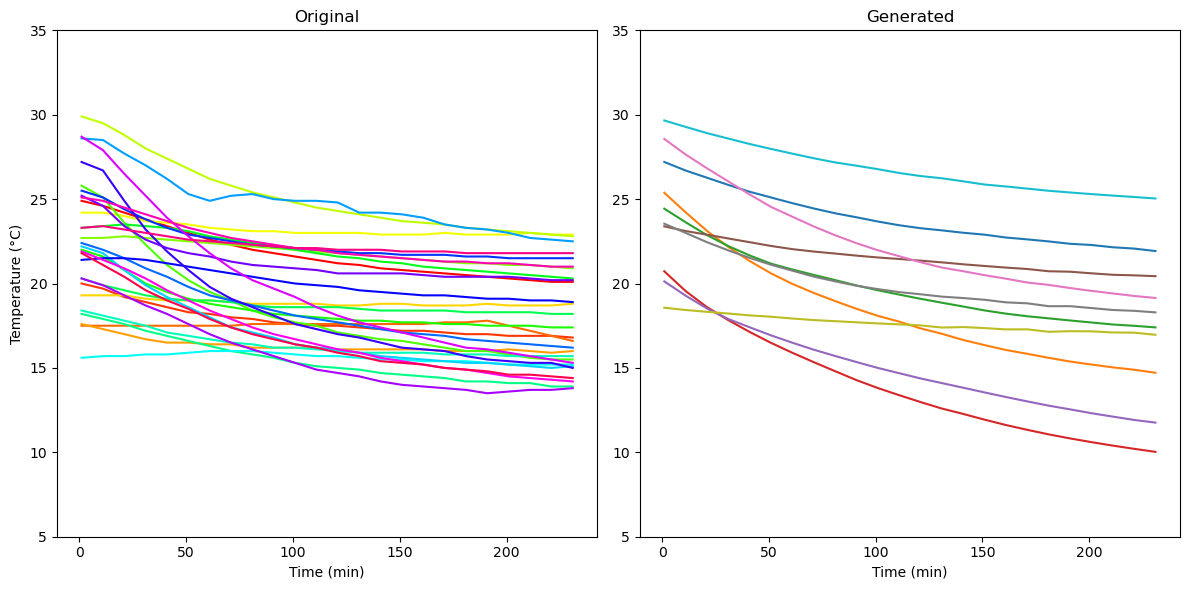

Training Progress:  49%|████▊     | 268/550 [00:17<00:17, 16.49it/s]

Epoch 270: Train Loss = 0.8393, KL_phy = 0.3075, KL_delta = 0.7776, MSE = 0.7479, CE = 0.1398, Reg_Loss = 1.0536, Alpha = 0.0764
Validation Loss = 1.8044, Val_KL_phy = 0.2654, Val_KL_delta = 0.3865, Val_MSE = 1.7447, Val_CE = 0.2001, Val_Reg_Loss = 0.6957, Val_Alpha = 0.0764


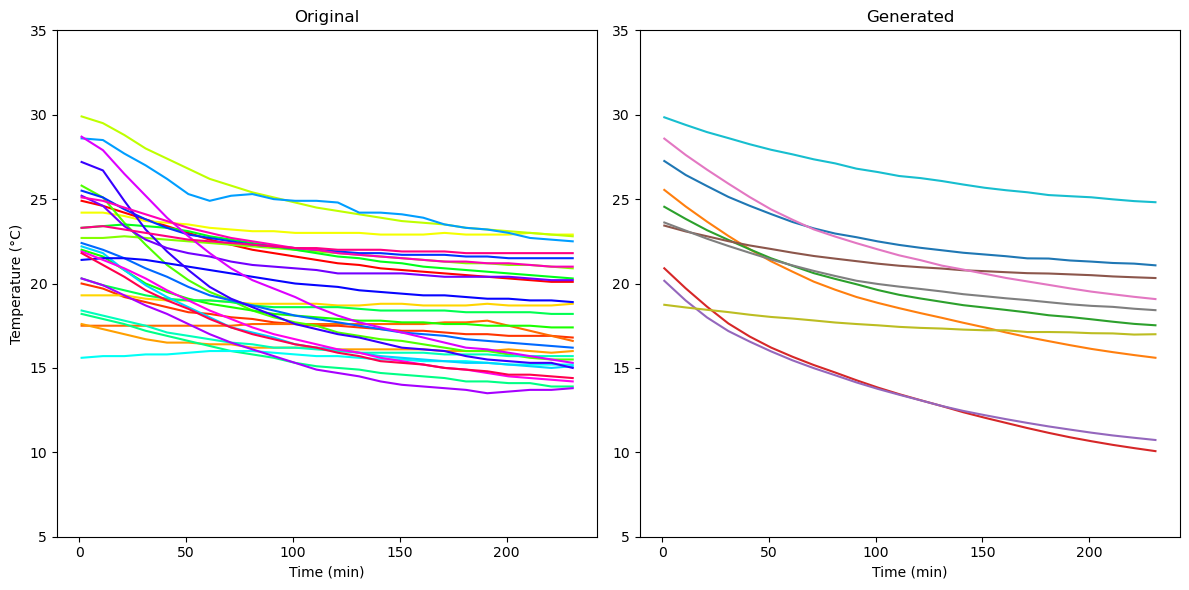

Training Progress:  54%|█████▍    | 296/550 [00:19<00:15, 16.55it/s]

Epoch 297: Train Loss = 0.9008, KL_phy = 0.3601, KL_delta = 1.0052, MSE = 0.8185, CE = 0.1448, Reg_Loss = 0.9201, Alpha = 0.0746
Validation Loss = 1.4181, Val_KL_phy = 0.3116, Val_KL_delta = 0.5418, Val_MSE = 1.3549, Val_CE = 0.1729, Val_Reg_Loss = 0.7331, Val_Alpha = 0.0746


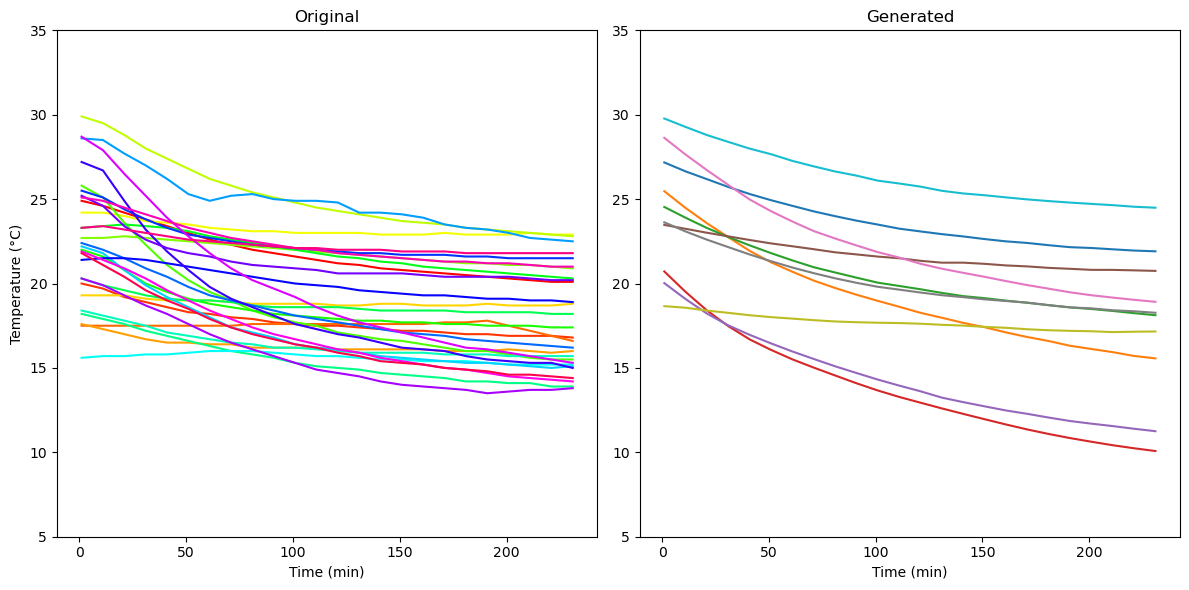

Training Progress:  59%|█████▊    | 322/550 [00:21<00:13, 16.49it/s]

Epoch 324: Train Loss = 0.7351, KL_phy = 0.3967, KL_delta = 1.3249, MSE = 0.6340, CE = 0.1509, Reg_Loss = 1.1496, Alpha = 0.0729
Validation Loss = 1.5155, Val_KL_phy = 0.3483, Val_KL_delta = 0.7471, Val_MSE = 1.4427, Val_CE = 0.1424, Val_Reg_Loss = 0.8486, Val_Alpha = 0.0729


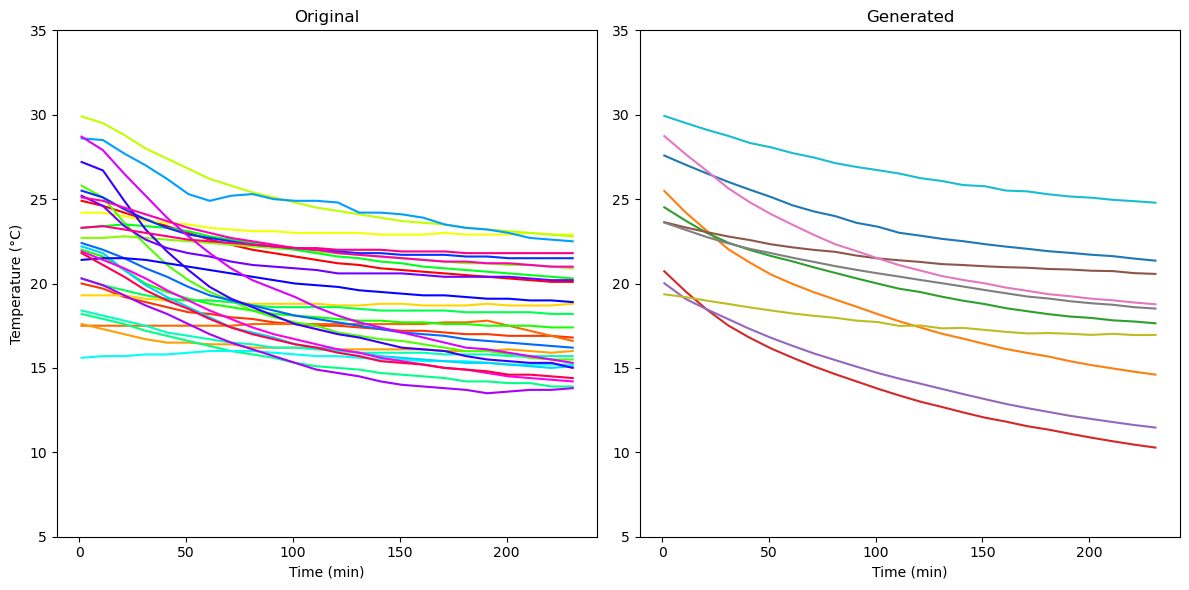

Training Progress:  64%|██████▎   | 350/550 [00:23<00:12, 16.53it/s]

Epoch 351: Train Loss = 0.7132, KL_phy = 0.4120, KL_delta = 1.5205, MSE = 0.6418, CE = 0.1657, Reg_Loss = 0.7293, Alpha = 0.0714
Validation Loss = 1.4854, Val_KL_phy = 0.3554, Val_KL_delta = 0.8491, Val_MSE = 1.4277, Val_CE = 0.1741, Val_Reg_Loss = 0.6390, Val_Alpha = 0.0714


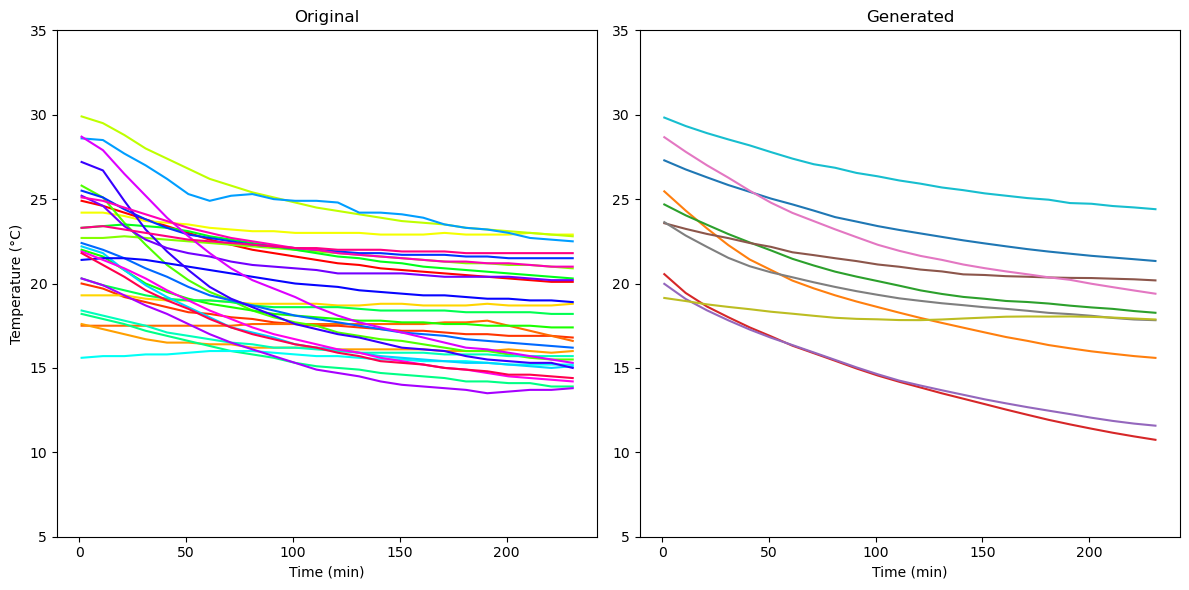

Training Progress:  68%|██████▊   | 376/550 [00:24<00:10, 16.49it/s]

Epoch 378: Train Loss = 0.6002, KL_phy = 0.4193, KL_delta = 1.9501, MSE = 0.4982, CE = 0.1724, Reg_Loss = 1.1181, Alpha = 0.0700
Validation Loss = 1.3077, Val_KL_phy = 0.3642, Val_KL_delta = 1.1449, Val_MSE = 1.2229, Val_CE = 0.1219, Val_Reg_Loss = 0.9951, Val_Alpha = 0.0700


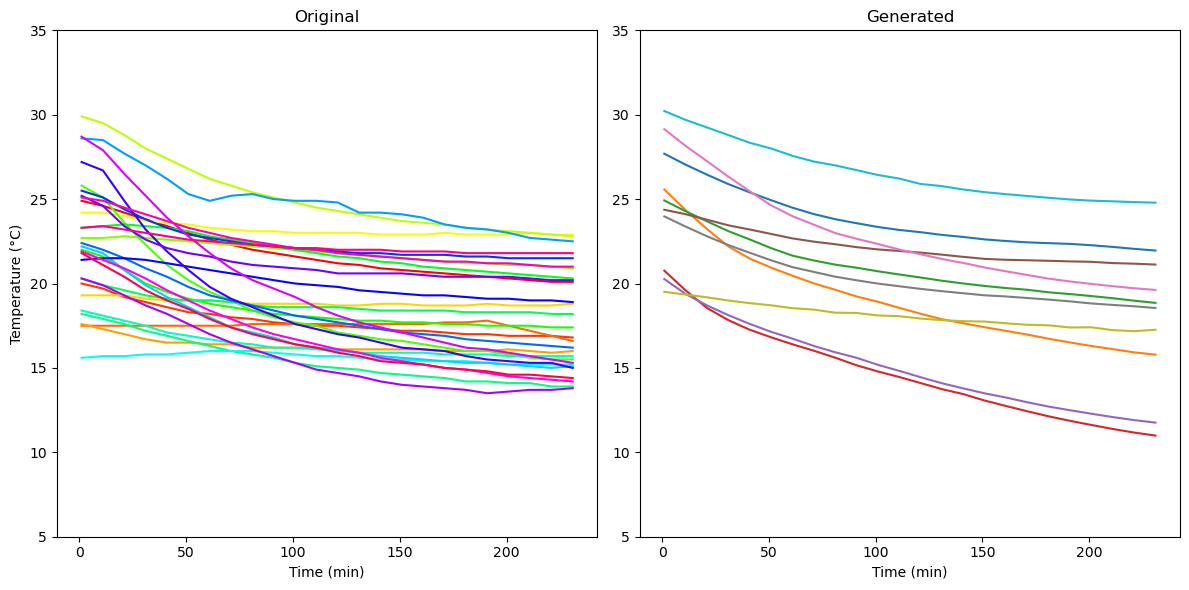

Training Progress:  73%|███████▎  | 404/550 [00:26<00:08, 16.59it/s]

Epoch 405: Train Loss = 0.6023, KL_phy = 0.4797, KL_delta = 2.4725, MSE = 0.4959, CE = 0.2129, Reg_Loss = 1.1182, Alpha = 0.0687
Validation Loss = 1.1899, Val_KL_phy = 0.4193, Val_KL_delta = 1.4196, Val_MSE = 1.1147, Val_CE = 0.1491, Val_Reg_Loss = 0.8263, Val_Alpha = 0.0687


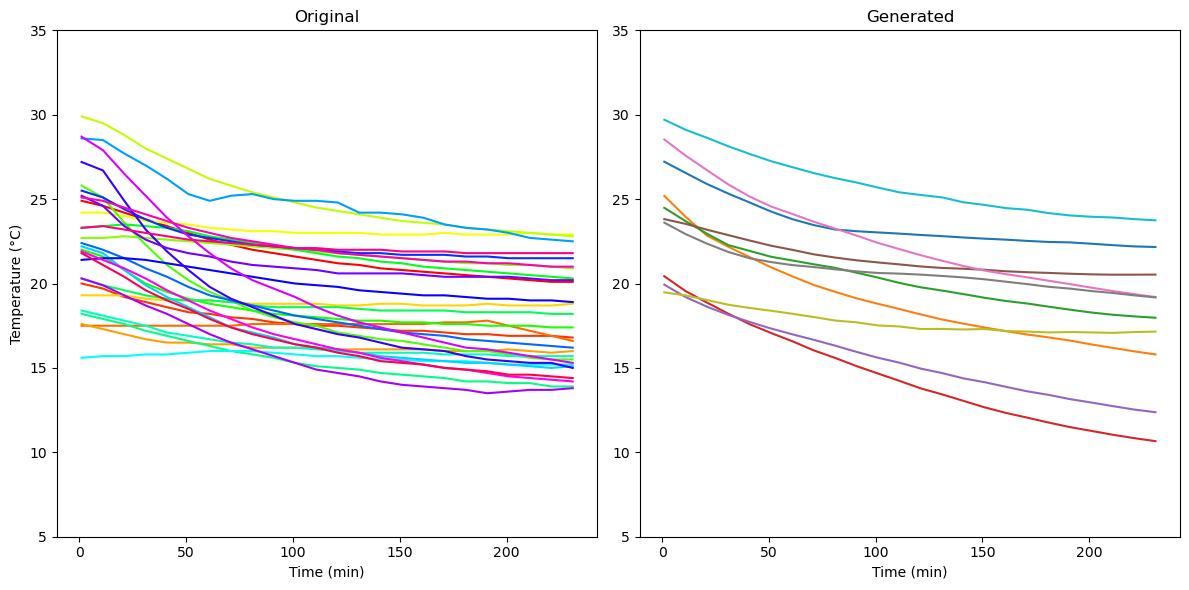

Training Progress:  78%|███████▊  | 430/550 [00:28<00:07, 16.52it/s]

Epoch 432: Train Loss = 0.6506, KL_phy = 0.5334, KL_delta = 2.8132, MSE = 0.5724, CE = 0.2178, Reg_Loss = 0.6611, Alpha = 0.0676
Validation Loss = 1.2696, Val_KL_phy = 0.4654, Val_KL_delta = 1.6456, Val_MSE = 1.1954, Val_CE = 0.1107, Val_Reg_Loss = 0.7851, Val_Alpha = 0.0676


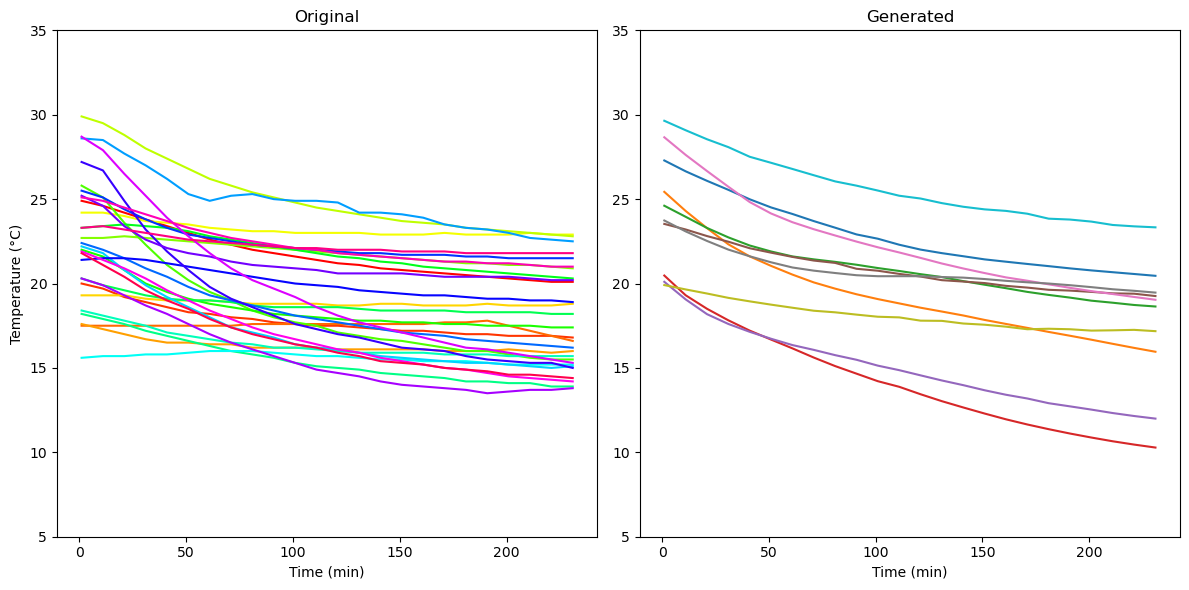

Training Progress:  83%|████████▎ | 458/550 [00:30<00:05, 16.58it/s]

Epoch 459: Train Loss = 0.4236, KL_phy = 0.5836, KL_delta = 3.1430, MSE = 0.3492, CE = 0.2372, Reg_Loss = 0.5577, Alpha = 0.0665
Validation Loss = 1.2146, Val_KL_phy = 0.5031, Val_KL_delta = 1.8251, Val_MSE = 1.1461, Val_CE = 0.1116, Val_Reg_Loss = 0.6795, Val_Alpha = 0.0665


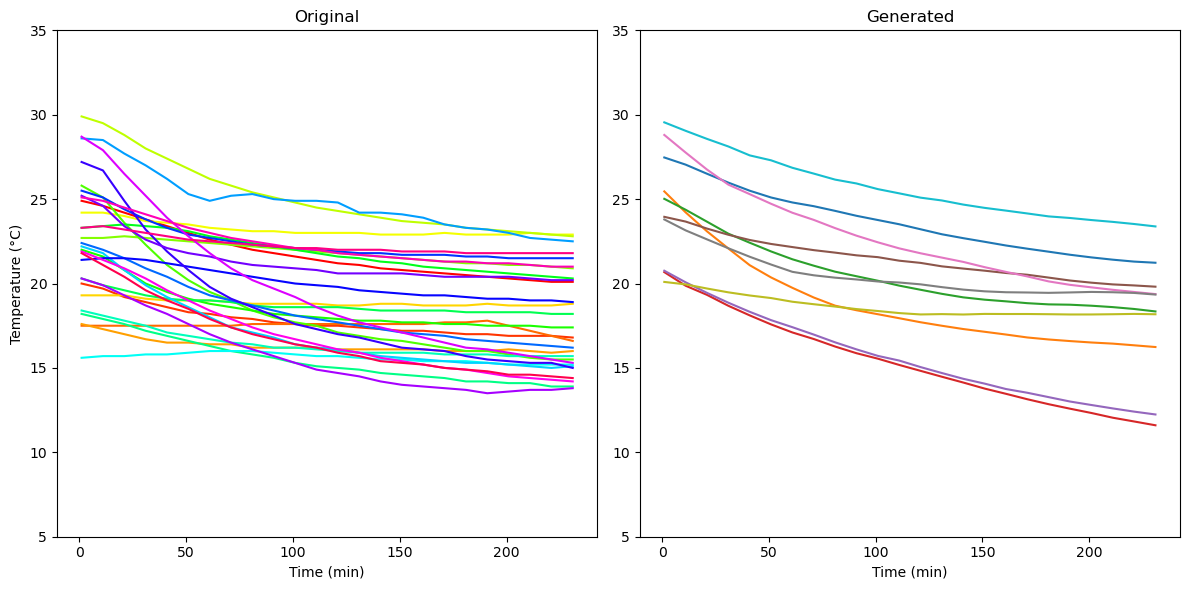

Training Progress:  88%|████████▊ | 484/550 [00:31<00:04, 16.49it/s]

Epoch 486: Train Loss = 0.3400, KL_phy = 0.6209, KL_delta = 3.5807, MSE = 0.2567, CE = 0.2656, Reg_Loss = 0.6298, Alpha = 0.0655
Validation Loss = 0.7853, Val_KL_phy = 0.5378, Val_KL_delta = 2.1923, Val_MSE = 0.6918, Val_CE = 0.1243, Val_Reg_Loss = 1.0123, Val_Alpha = 0.0655


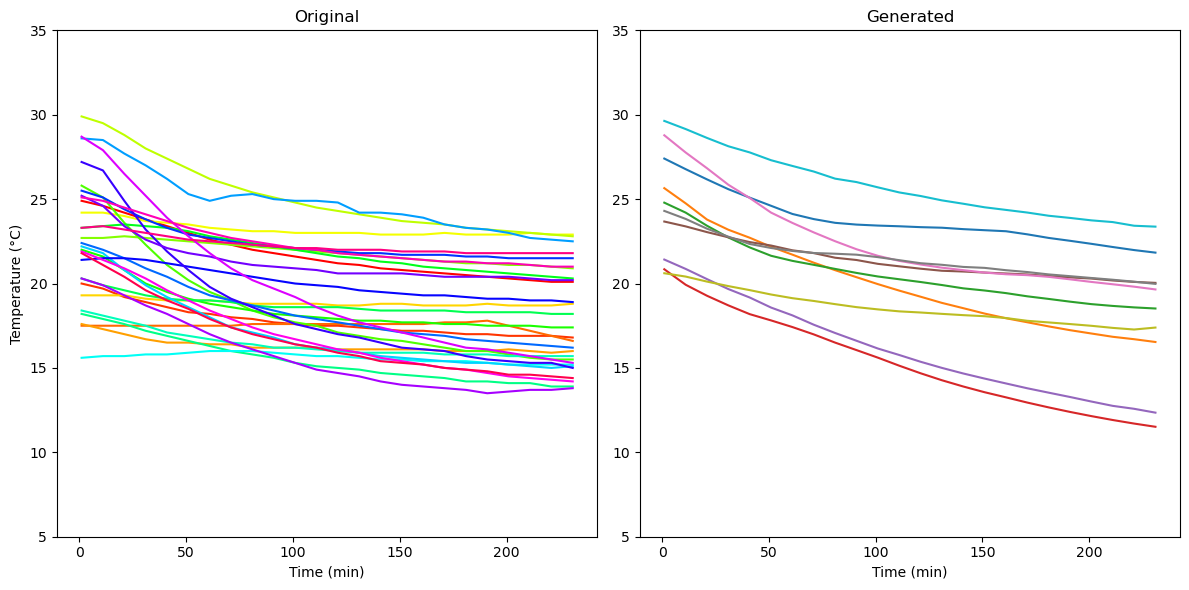

Training Progress:  93%|█████████▎| 512/550 [00:33<00:02, 16.58it/s]

Epoch 513: Train Loss = 0.2792, KL_phy = 0.6761, KL_delta = 3.9295, MSE = 0.1935, CE = 0.2898, Reg_Loss = 0.6155, Alpha = 0.0644
Validation Loss = 0.7091, Val_KL_phy = 0.5858, Val_KL_delta = 2.3482, Val_MSE = 0.6185, Val_CE = 0.1310, Val_Reg_Loss = 0.9510, Val_Alpha = 0.0644


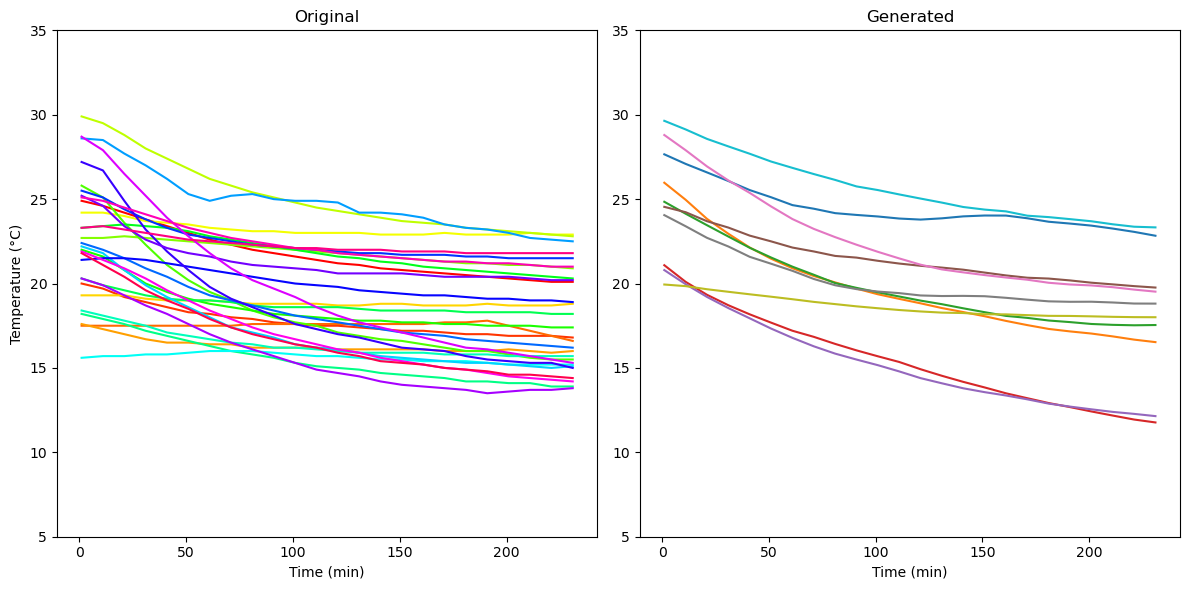

Training Progress:  98%|█████████▊| 538/550 [00:35<00:00, 16.47it/s]

Epoch 540: Train Loss = 0.4010, KL_phy = 0.7104, KL_delta = 4.2006, MSE = 0.2945, CE = 0.3088, Reg_Loss = 0.9064, Alpha = 0.0633
Validation Loss = 0.8435, Val_KL_phy = 0.6132, Val_KL_delta = 2.3948, Val_MSE = 0.7680, Val_CE = 0.1357, Val_Reg_Loss = 0.7175, Val_Alpha = 0.0633


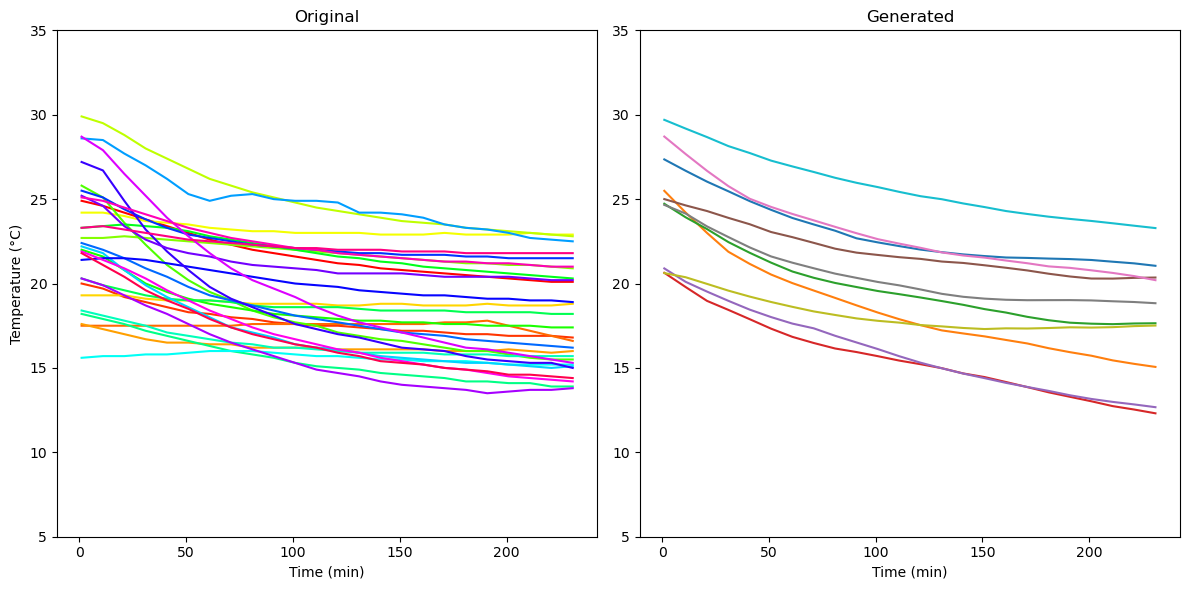

Training Progress: 100%|█████████▉| 548/550 [00:36<00:00, 15.17it/s]

Epoch 550: Train Loss = 0.3209, KL_phy = 0.7126, KL_delta = 4.0958, MSE = 0.2246, CE = 0.3041, Reg_Loss = 0.7663, Alpha = 0.0629
Validation Loss = 0.7047, Val_KL_phy = 0.6158, Val_KL_delta = 2.4667, Val_MSE = 0.6165, Val_CE = 0.1396, Val_Reg_Loss = 0.9124, Val_Alpha = 0.0629


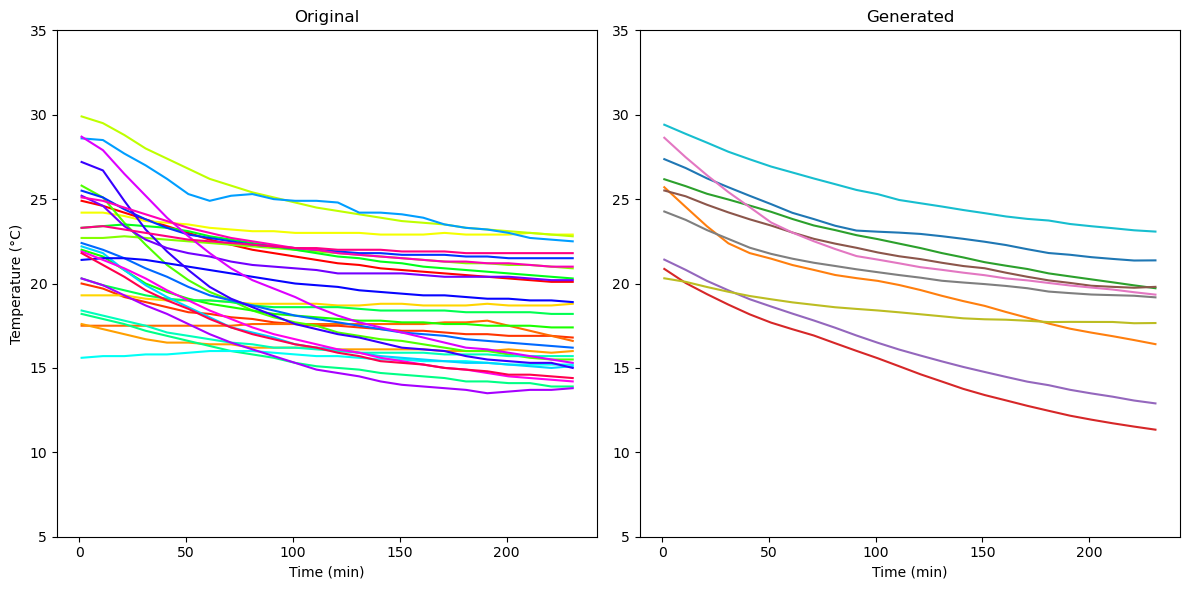

Training Progress: 100%|██████████| 550/550 [00:36<00:00, 15.08it/s]


In [9]:
"""
# works well
beta=0.01
beta_delta=beta#*0.001
"""
# beta=0.01
# beta=0.05

# beta_delta=beta
# beta_phy=beta
# Training configuration
# num_epochs=1000
num_epochs=550
epochs=range(num_epochs)

annealing_strategy = AnnealingStrategy(strategy='linear', 
                                       total_epochs=num_epochs, 
                                       beta_min=0.01, 
                                       beta_max=0.01)

"""
annealing_strategy = AnnealingStrategy(strategy='linear', 
                                       total_epochs=num_epochs, 
                                       beta_min=0.1, 
                                       beta_max=0.1)
"""
beta_annealed = annealing_strategy.get_beta_vector()
# beta_annealed = torch.tensor(beta_annealed)
beta_delta=beta_annealed
beta_phy=beta_annealed
ns = 10
min_T, max_T = 15, 30
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (15 - 1) * torch.rand(ns)
Ts = T0 - difference
unique_intervals = df_c['interval'].unique()
num_unique_intervals = len(unique_intervals)

fit_res = model.fit(train_loader=train_loader, 
                    val_loader=val_loader, 
                    opt=opt, 
                    beta_delta=beta_delta,
                    beta_phy=beta_phy,
                    num_epochs=num_epochs,
                   seed=0, plot=True, df=df_c, ns=ns, T0=T0, Ts=Ts, t_uni=t_uni/240, axs_ylim=(5, 35))
# !!! Make it works with plot=True

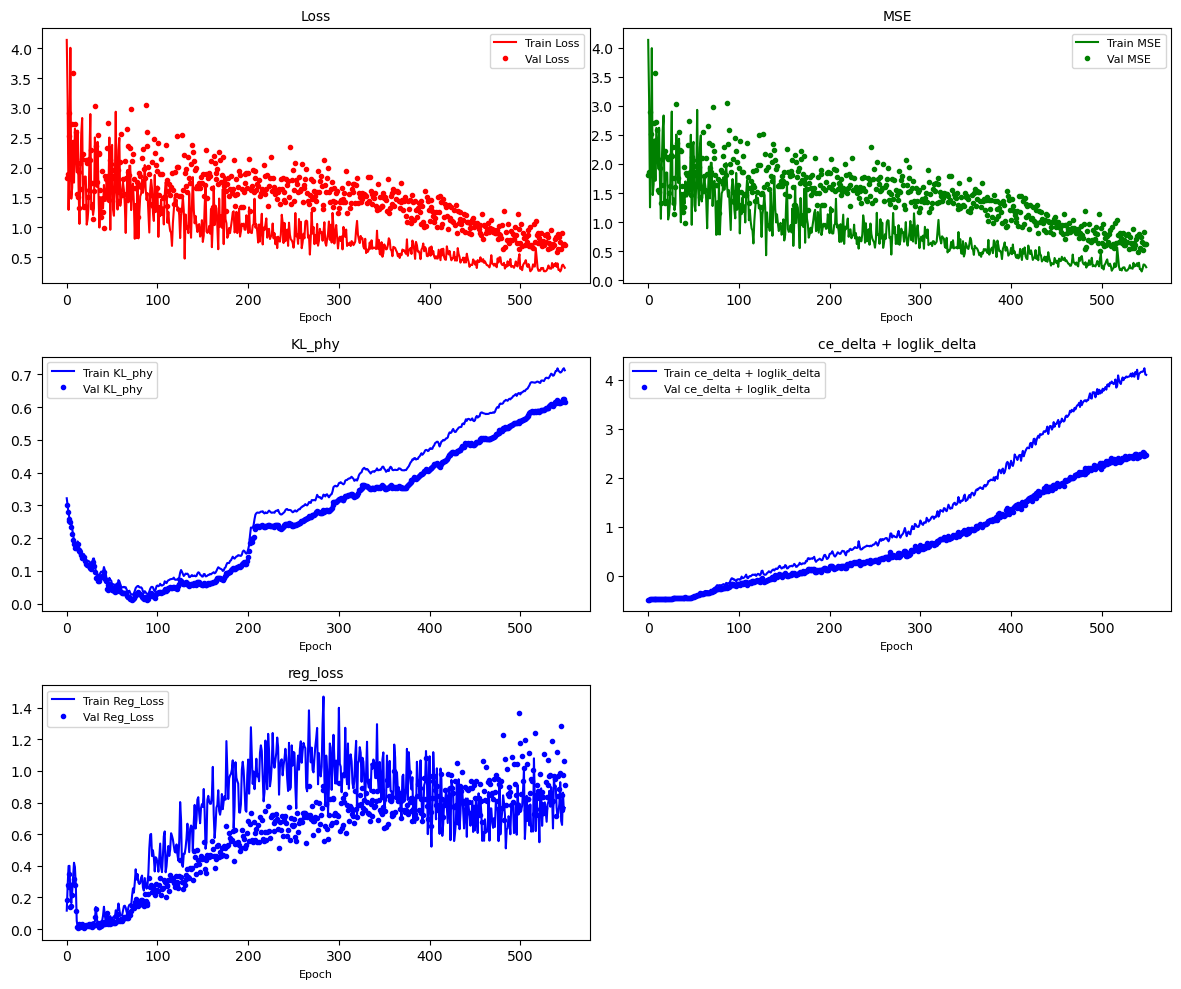

In [10]:
# Extract quantities for plotting
epochs = fit_res['epochs']
l_loss = fit_res['train_loss']
val_loss = fit_res['val_loss']
mse = fit_res['train_mse']
val_mse = fit_res['val_mse']
KL_phy = fit_res['train_KL_phy']
val_KL_phy = fit_res['val_KL_phy']
KL_delta = fit_res['train_KL_delta']
val_KL_delta = fit_res['val_KL_delta']
reg_loss = fit_res['train_reg_loss']
val_reg_loss = fit_res['val_reg_loss']

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(12, 10))  # Keeping original figure size

# Loss plot (train vs. validation)
axs[0, 0].plot(epochs, l_loss, 'r-', label='Train Loss')
axs[0, 0].plot(epochs, val_loss, 'ro', label='Val Loss', markersize=3)  # Only points for validation
axs[0, 0].set_title('Loss', fontsize=10)
axs[0, 0].set_xlabel('Epoch', fontsize=8)
axs[0, 0].legend(fontsize=8)

# MSE plot (train vs. validation)
axs[0, 1].plot(epochs, mse, 'g-', label='Train MSE')
axs[0, 1].plot(epochs, val_mse, 'go', label='Val MSE', markersize=3)  # Only points for validation
axs[0, 1].set_title('MSE', fontsize=10)
axs[0, 1].set_xlabel('Epoch', fontsize=8)
axs[0, 1].legend(fontsize=8)

# KL Divergence (train vs. validation)
axs[1, 0].plot(epochs, KL_phy, 'b-', label='Train KL_phy')
axs[1, 0].plot(epochs, val_KL_phy, 'bo', label='Val KL_phy', markersize=3)  # Only points for validation
axs[1, 0].set_title('KL_phy', fontsize=10)
axs[1, 0].set_xlabel('Epoch', fontsize=8)
axs[1, 0].legend(fontsize=8)

# KL_delta + loglik_delta (train vs. validation)
axs[1, 1].plot(epochs, KL_delta, 'b-', label='Train ce_delta + loglik_delta')
axs[1, 1].plot(epochs, val_KL_delta, 'bo', label='Val ce_delta + loglik_delta', markersize=3)  # Only points for validation
axs[1, 1].set_title('ce_delta + loglik_delta', fontsize=10)
axs[1, 1].set_xlabel('Epoch', fontsize=8)
axs[1, 1].legend(fontsize=8)

# Regularization loss (train vs. validation) - Spanning entire third row
axs[2, 0].plot(epochs, reg_loss, 'b-', label='Train Reg_Loss')
axs[2, 0].plot(epochs, val_reg_loss, 'bo', label='Val Reg_Loss', markersize=3)  # Only points for validation
axs[2, 0].set_title('reg_loss', fontsize=10)
axs[2, 0].set_xlabel('Epoch', fontsize=8)
axs[2, 0].legend(fontsize=8)

# Remove empty subplot (since we have 5 plots, and this grid would have 6 subplots)
fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

In [11]:
q_mu_delta_l, q_var_delta_l, q_mu_phy_l, q_var_phy_l, x_hat_l, x_hat_phy_l, x_hat_delta_l, = [], [], [], [], [], [], []
batches_data = []
# Iterate through the train_loader to obtain x_batch
for x_batch in train_loader:
    with torch.no_grad():
        x_batch = x_batch.squeeze(0)  # Remove the batch dimension if necessary

        x_hat_i, x_hat_phy_i, x_hat_delta_i, _, _, _, q_mu_delta_i, q_var_delta_i, q_mu_phy_i, q_var_phy_i = model(x_batch)

        q_mu_delta_l.append(q_mu_delta_i)
        q_var_delta_l.append(q_var_delta_i)
        q_mu_phy_l.append(q_mu_phy_i)
        q_var_phy_l.append(q_var_phy_i)
        x_hat_l.append(x_hat_i)
        x_hat_phy_l.append(x_hat_phy_i)
        x_hat_delta_l.append(x_hat_delta_i)
        batches_data.append(x_batch)
        
mean_q_mu_phy = sum(q_mu_phy_l) / len(q_mu_phy_l)
mean_q_var_phy = sum(q_var_phy_l) / len(q_var_phy_l)
mu_s = torch.cat(q_mu_delta_l, dim=1).mean(dim=1).unsqueeze(1)


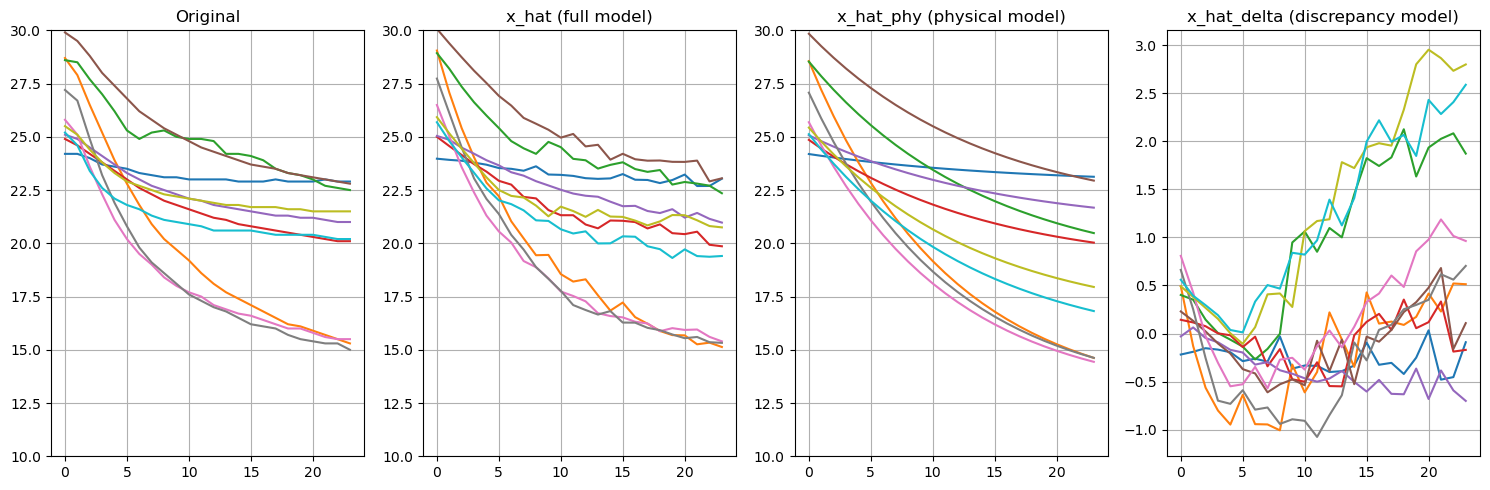

In [12]:
x_hat_numpy = [x_hat_l[sa].numpy() for sa in range(len(x_hat_l))]
batches_data_numpy = [batches_data[sa][:, 0].unsqueeze(1).numpy() for sa in range(len(batches_data))]
x_hat_phy_numpy = [x_hat_phy_l[sa].numpy() for sa in range(len(x_hat_phy_l))]
x_hat_delta_numpy = [x_hat_delta_l[sa].numpy() for sa in range(len(x_hat_delta_l))]

# Number of subplots is the length of the lists (assuming all have the same length)
num_plots = len(x_hat_numpy)

# Create subplots - 1 row, 4 columns
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Plot each list in a separate subplot
for i in range(num_plots):
    # First subplot
    axs[0].plot(batches_data_numpy[i], label=f'batches_data[{i}]')
    axs[0].set_title('Original')
    axs[0].set_ylim(10, 30)
    
    # Second subplot
    axs[1].plot(x_hat_numpy[i], label=f'x_hat_l[{i}]')
    axs[1].set_title('x_hat (full model)')
    axs[1].set_ylim(10, 30)
    
    # Third subplot
    axs[2].plot(x_hat_phy_numpy[i], label=f'x_hat_phy_l[{i}]')
    axs[2].set_title('x_hat_phy (physical model)')
    axs[2].set_ylim(10, 30)
    
    # Fourth subplot
    axs[3].plot(x_hat_delta_numpy[i], label=f'x_hat_delta_l[{i}]')
    axs[3].set_title('x_hat_delta (discrepancy model)')

# Add legends to each subplot
for ax in axs:
    ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


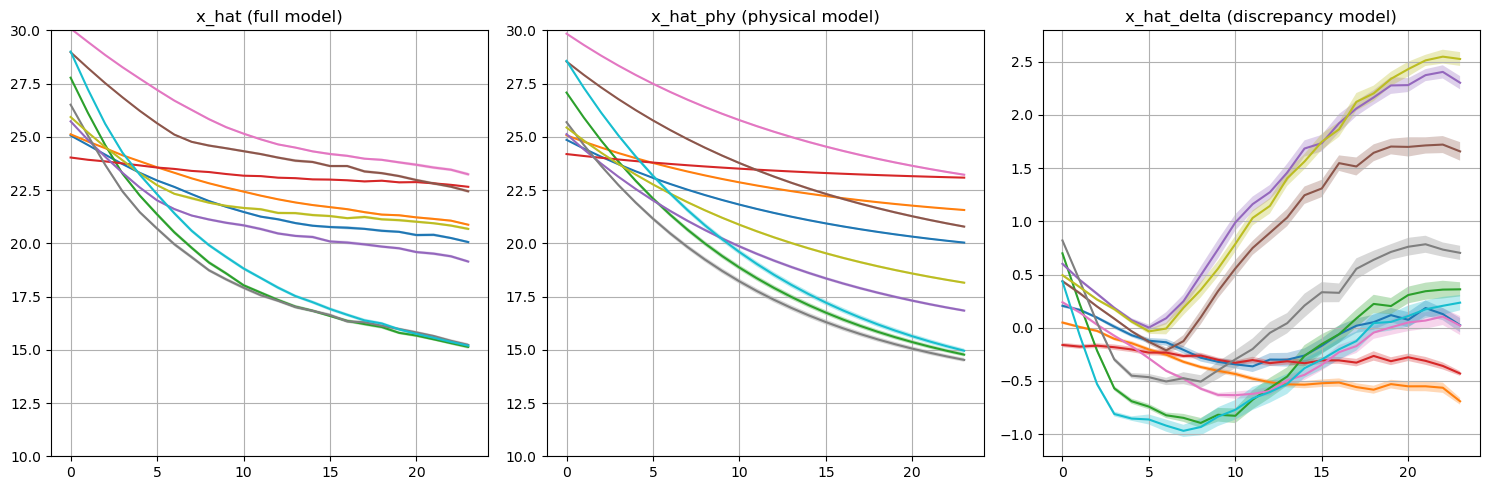

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute mean and 95% CI
def compute_mean_and_ci(samples):
    samples = np.array(samples)  # Ensure it's a NumPy array
    mean = np.mean(samples, axis=0)  # Mean across samples
    std = np.std(samples, axis=0)   # Standard deviation
    ci = 1.96 * (std / np.sqrt(samples.shape[0]))  # 95% CI using SEM
    return mean, mean - ci, mean + ci

# Initialize lists to store multiple samples
x_hat_samples, x_hat_phy_samples, x_hat_delta_samples = [], [], []

# Number of samples to generate for each quantity
num_samples = 50

# Iterate through the train_loader to obtain x_batch
for x_batch in train_loader:
    x_batch = x_batch.squeeze(0)  # Remove the batch dimension if necessary
    x_hat_batch, x_hat_phy_batch, x_hat_delta_batch = [], [], []
    
    for _ in range(num_samples):
        with torch.no_grad():
            x_hat_i, x_hat_phy_i, x_hat_delta_i, _, _, _, q_mu_delta_i, q_var_delta_i, q_mu_phy_i, q_var_phy_i = model(x_batch)
            x_hat_batch.append(x_hat_i.numpy().flatten())  # Flatten to 1D
            x_hat_phy_batch.append(x_hat_phy_i.numpy().flatten())
            x_hat_delta_batch.append(x_hat_delta_i.numpy().flatten())
    
    # Store all samples for the batch
    x_hat_samples.append(np.stack(x_hat_batch))  # Shape: [num_samples, seq_len]
    x_hat_phy_samples.append(np.stack(x_hat_phy_batch))
    x_hat_delta_samples.append(np.stack(x_hat_delta_batch))

# Plot results with mean and 95% CI
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (x_hat, x_hat_phy, x_hat_delta) in enumerate(zip(x_hat_samples, x_hat_phy_samples, x_hat_delta_samples)):
    # Compute mean and CI for each quantity
    mean_x_hat, lower_x_hat, upper_x_hat = compute_mean_and_ci(x_hat)
    mean_x_hat_phy, lower_x_hat_phy, upper_x_hat_phy = compute_mean_and_ci(x_hat_phy)
    mean_x_hat_delta, lower_x_hat_delta, upper_x_hat_delta = compute_mean_and_ci(x_hat_delta)

    # Plot Full Model
    axs[0].plot(mean_x_hat, label=f'Batch {i} Mean')
    axs[0].fill_between(range(len(mean_x_hat)), lower_x_hat, upper_x_hat, alpha=0.3, label=f'Batch {i} CI')
    axs[0].set_title('x_hat (full model)')
    axs[0].set_ylim(10, 30)

    # Plot Physical Model
    axs[1].plot(mean_x_hat_phy, label=f'Batch {i} Mean')
    axs[1].fill_between(range(len(mean_x_hat_phy)), lower_x_hat_phy, upper_x_hat_phy, alpha=0.3, label=f'Batch {i} CI')
    axs[1].set_title('x_hat_phy (physical model)')
    axs[1].set_ylim(10, 30)

    # Plot Discrepancy Model
    axs[2].plot(mean_x_hat_delta, label=f'Batch {i} Mean')
    axs[2].fill_between(range(len(mean_x_hat_delta)), lower_x_hat_delta, upper_x_hat_delta, alpha=0.3, label=f'Batch {i} CI')
    axs[2].set_title('x_hat_delta (discrepancy model)')
    #axs[2].set_ylim(10, 30)

# Add legends and display the plot
for ax in axs:
    ax.grid(True)

plt.tight_layout()
plt.show()


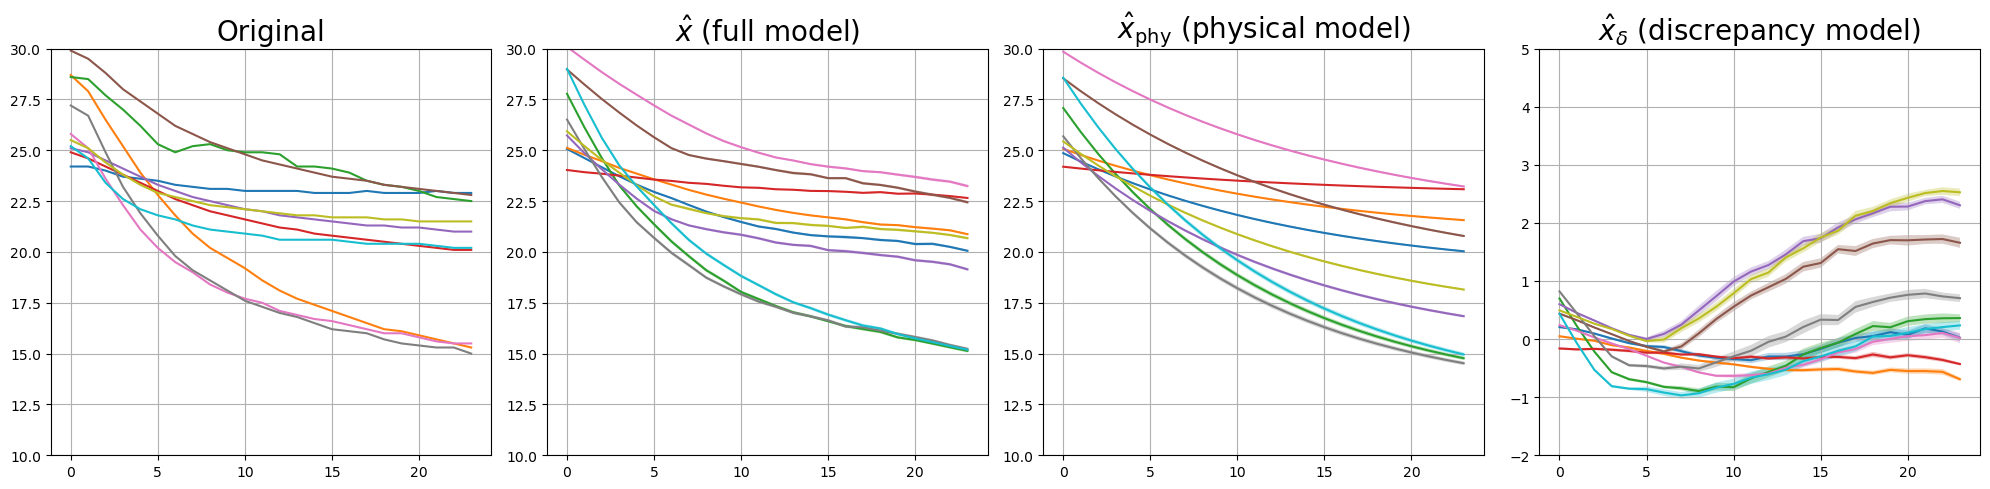

In [14]:
# Plot results with four subplots: real data, full model, physical model, discrepancy model
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Font size for titles
title_fontsize = 20

# Plot Real Data (outside the loop)
for i in range(num_plots):
    # First subplot
    axs[0].plot(batches_data_numpy[i], label=f'batches_data[{i}]')
    axs[0].set_title(r'Original', fontsize=title_fontsize)
    axs[0].set_ylim(10, 30)

# Plot reconstructed quantities for each batch
for i, (x_hat, x_hat_phy, x_hat_delta) in enumerate(zip(x_hat_samples, x_hat_phy_samples, x_hat_delta_samples)):
    # Compute mean and CI for each quantity
    mean_x_hat, lower_x_hat, upper_x_hat = compute_mean_and_ci(x_hat)
    mean_x_hat_phy, lower_x_hat_phy, upper_x_hat_phy = compute_mean_and_ci(x_hat_phy)
    mean_x_hat_delta, lower_x_hat_delta, upper_x_hat_delta = compute_mean_and_ci(x_hat_delta)

    # Plot Full Model
    axs[1].plot(mean_x_hat, label=f'Batch {i} Mean')
    axs[1].fill_between(range(len(mean_x_hat)), lower_x_hat, upper_x_hat, alpha=0.3, label=f'Batch {i} CI')
    axs[1].set_title(r'$\hat{x}$ (full model)', fontsize=title_fontsize)
    axs[1].set_ylim(10, 30)

    # Plot Physical Model
    axs[2].plot(mean_x_hat_phy, label=f'Batch {i} Mean')
    axs[2].fill_between(range(len(mean_x_hat_phy)), lower_x_hat_phy, upper_x_hat_phy, alpha=0.3, label=f'Batch {i} CI')
    axs[2].set_title(r'$\hat{x}_{\text{phy}}$ (physical model)', fontsize=title_fontsize)
    axs[2].set_ylim(10, 30)

    # Plot Discrepancy Model
    axs[3].plot(mean_x_hat_delta, label=f'Batch {i} Mean')
    axs[3].fill_between(range(len(mean_x_hat_delta)), lower_x_hat_delta, upper_x_hat_delta, alpha=0.3, label=f'Batch {i} CI')
    axs[3].set_title(r'$\hat{x}_\delta$ (discrepancy model)', fontsize=title_fontsize)
    axs[3].set_ylim(-2, 5)

# Add legends to reconstructed plots
for ax in axs[0:]:
    # ax.legend()
    ax.grid(True)

# Save the plot as a PDF
plt.tight_layout()
plt.savefig("figs/PIGPVAE_reconstructions_cooling.pdf", format="pdf", bbox_inches="tight")

# Display the plot
plt.show()


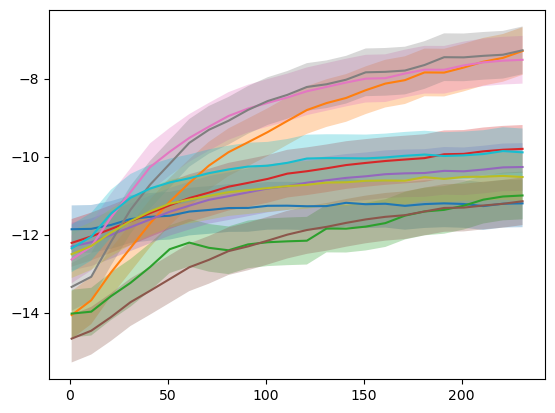

In [15]:
for l in range(len(q_mu_delta_l)):
    with torch.no_grad():
        z_mu, z_var = model.GP.cond_mu_cov(t_uni, t_uni, q_mu_delta_l[l], q_var_delta_l[l].squeeze())
        plt.plot(t_uni,z_mu)
        plt.fill_between(t_uni, y1=z_mu.squeeze()+1.96*z_var.diag().sqrt(), y2=z_mu.squeeze()-1.96*z_var.diag().sqrt(),alpha=0.3, label='1.96*std')
plt.show()  #

In [16]:
mu_s = torch.cat(q_mu_delta_l, dim=1).mean(dim=1).unsqueeze(1)

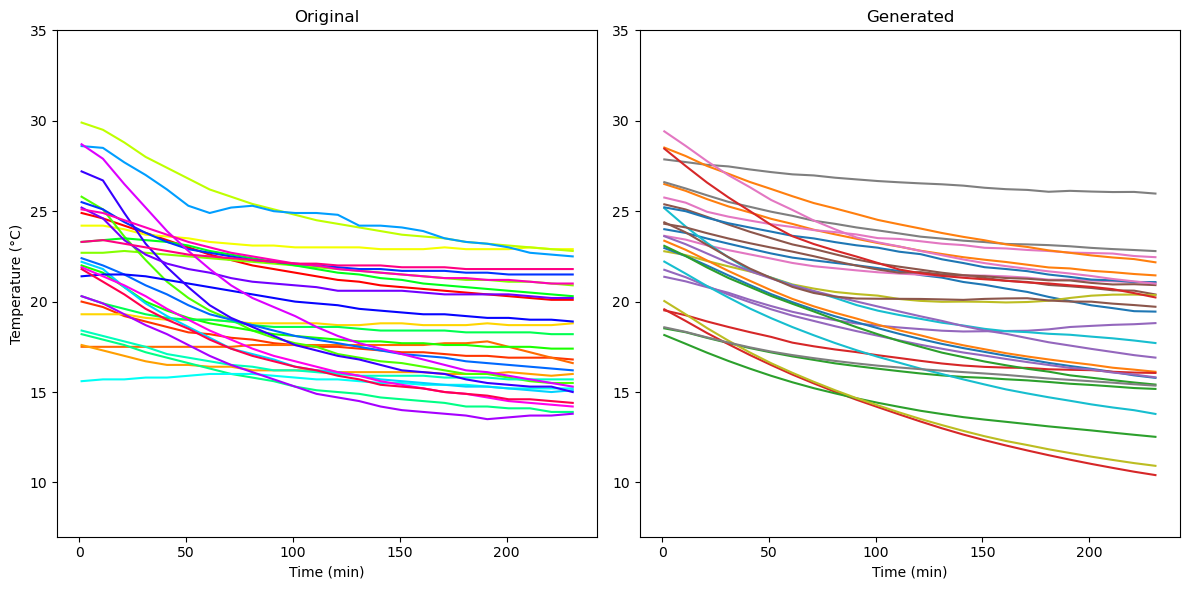

In [31]:
total_size = len(dataset)
ns = total_size
min_T, max_T = 15, 30
torch.manual_seed(0)
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (12 - 1) * torch.rand(ns)
Ts = T0 - difference
unique_intervals = df_c['interval'].unique()
num_unique_intervals = len(unique_intervals)
k_values, generated_data, fig, axs=model.generate_and_plot(mu_s, 
                        mean_q_mu_phy, 
                        mean_q_var_phy,
                        df=df_c,
                        num_unique_intervals=num_unique_intervals, 
                        ns=ns, 
                        T0=T0, 
                        Ts=Ts, 
                        t_uni=t_uni/240, 
                        axs_ylim=(7, 35),
                        plot=True, seed=0)

In [32]:
import tsgm
mmd_metric = tsgm.metrics.MMDMetric()
Gd = torch.stack(generated_data)
full_data = DataLoader(dataset)
original_data_list = []

# Iterate through the DataLoader
for batch in full_data:
    # Each batch is expected to be of shape [24, 1]
    # Add to the list
    original_data_list.append(batch[0][:,0])

# Stack to create a tensor of shape [total_samples, 24, 1]
original_data = torch.stack(original_data_list)
original_data = original_data.unsqueeze(-1)
# Check the shape
# print(original_data.shape)
mmd_metric(original_data, Gd)

0.07083428837358952

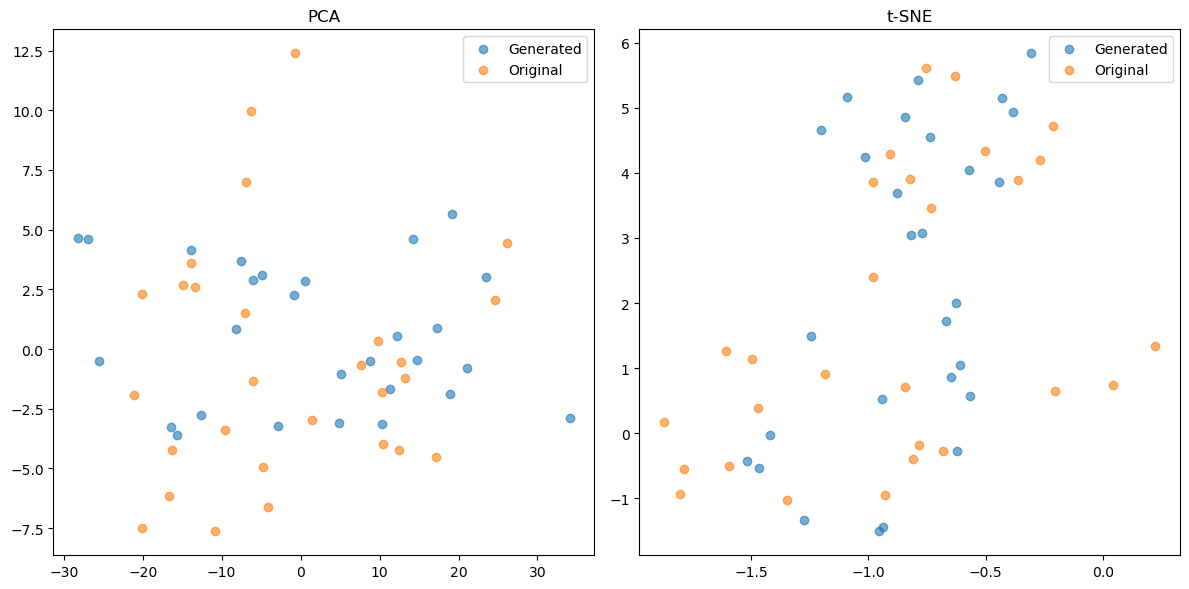

In [33]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


Gd_reshaped = Gd.view(Gd.size(0), -1).numpy()
original_data_reshaped = original_data.view(original_data.size(0), -1).numpy()

data_combined = np.concatenate([Gd_reshaped, original_data_reshaped], axis=0)
labels = np.array(['Generated'] * Gd.size(0) + ['Original'] * original_data.size(0))

# PCA Visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_combined)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for label in np.unique(labels):
    plt.scatter(pca_result[labels == label, 0], pca_result[labels == label, 1], label=label, alpha=0.6)
plt.title("PCA")

plt.legend()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_combined)

plt.subplot(1, 2, 2)
for label in np.unique(labels):
    plt.scatter(tsne_result[labels == label, 0], tsne_result[labels == label, 1], label=label, alpha=0.6)
plt.title("t-SNE")

plt.legend()

plt.tight_layout()
plt.show()

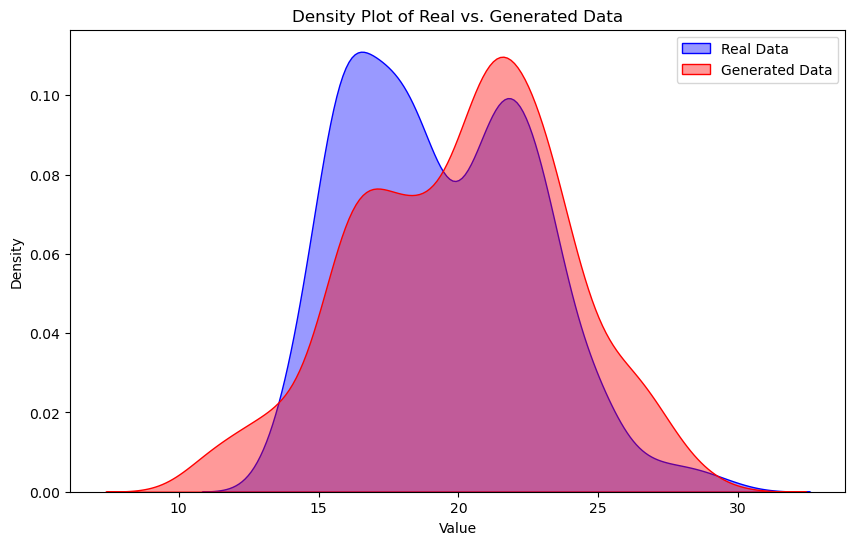

In [34]:
# Flatten the real and generated data to be one-dimensional
original_data_flattened = original_data.view(-1).numpy()
generated_data_flattened = Gd.view(-1).numpy()

# Plot overlapping density plots
plt.figure(figsize=(10, 6))
sns.kdeplot(original_data_flattened, label="Real Data", color="blue", fill=True, alpha=0.4)
sns.kdeplot(generated_data_flattened, label="Generated Data", color="red", fill=True, alpha=0.4)

# Customize plot
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Real vs. Generated Data')
plt.legend()
plt.show()


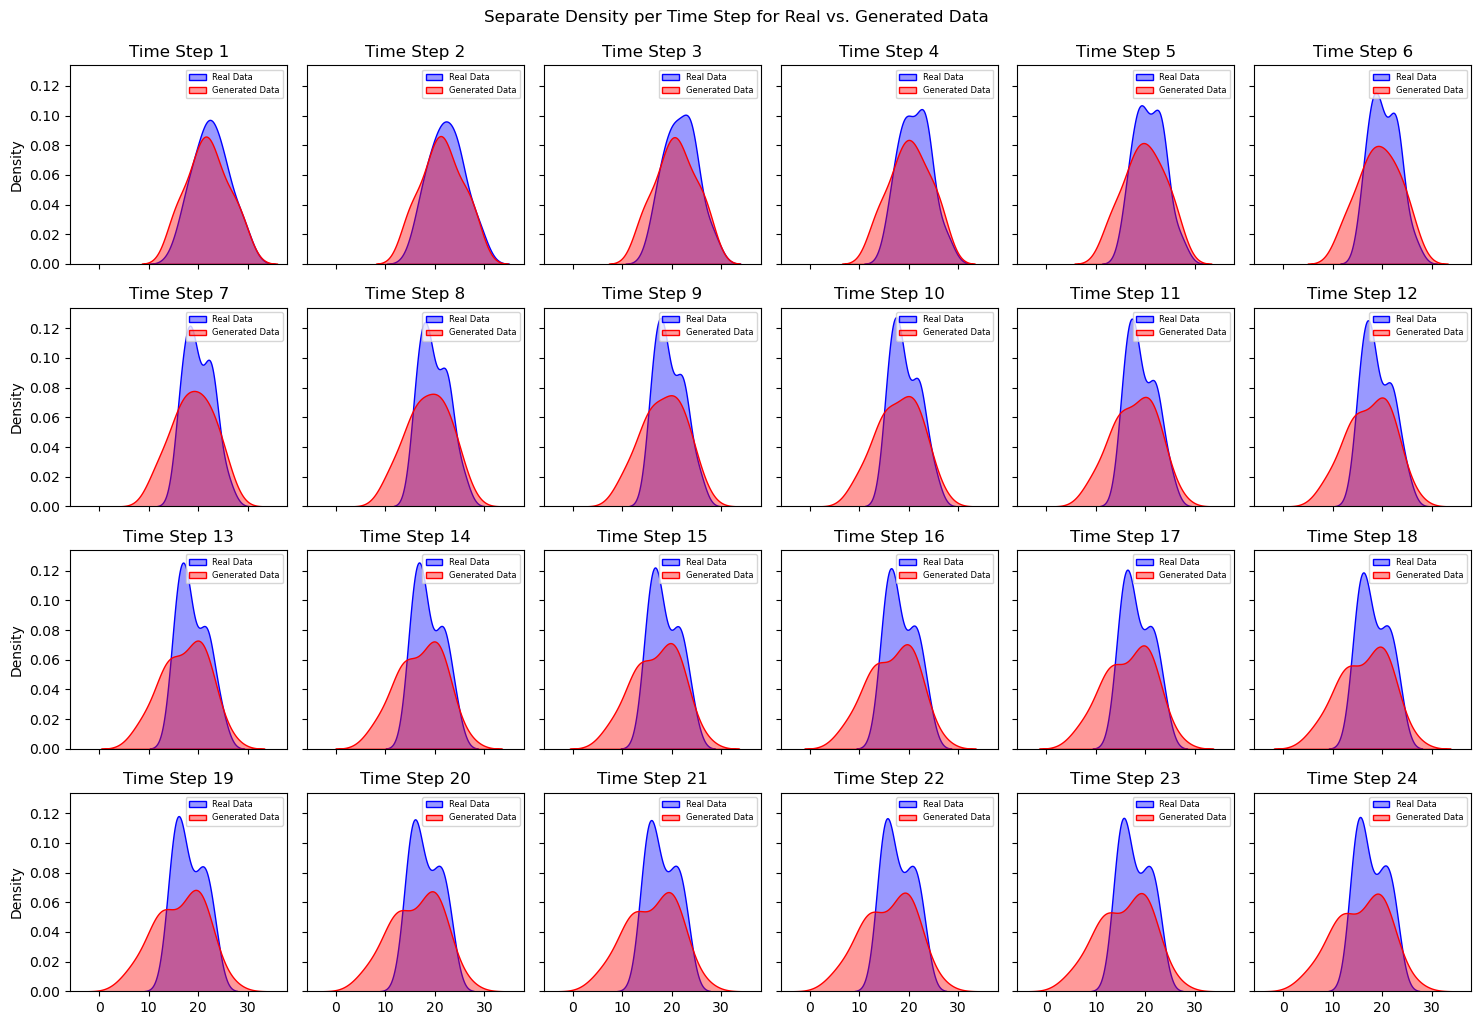

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for real and generated samples
original_data_windowed = original_data.view(28, 24).numpy()  # shape (28, 24)
generated_data_windowed = Gd.view(ns, 24).numpy()  # shape (ns, 24)

# Set up the number of subplots (one for each time step)
num_time_steps = 24
fig, axes = plt.subplots(4, 6, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Loop through each time step and plot density
for t in range(num_time_steps):
    # Extract the values at time step `t` for real and generated data
    real_values_at_t = original_data_windowed[:, t]
    generated_values_at_t = generated_data_windowed[:, t]
    
    # Plot density for real and generated data at each time step
    sns.kdeplot(real_values_at_t, ax=axes[t], label="Real Data", color="blue", fill=True, alpha=0.4)
    sns.kdeplot(generated_values_at_t, ax=axes[t], label="Generated Data", color="red", fill=True, alpha=0.4)
    
    # Label each subplot
    axes[t].set_title(f'Time Step {t + 1}')
    axes[t].legend(loc='upper right', fontsize=6)

# Adjust layout and add global labels
plt.tight_layout()
fig.suptitle('Separate Density per Time Step for Real vs. Generated Data', y=1.02)
plt.show()


In [22]:
torch.save(model.state_dict(), 'pre_trained_models/PIGPVAE_cooling.pth')